In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import probtorch
import torch

from combinators.inference.importance import Propose
from combinators.inference import importance, mcmc
import combinators.model as model
from combinators.model import foldable
import combinators
import combinators.utils as utils

from examples.ssm import ssm

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0.0

In [5]:
ssm_initializer = model.Deterministic(zs[0], mu, sigma, delta, batch_shape=(1,))
ssm_step = foldable.Step(ssm.SsmStep(batch_shape=(1,)), initializer=ssm_initializer)
ssm_sequence = foldable.Reduce(ssm_step, generator=lambda: range(zs.shape[0]-1))

In [6]:
_, generative, _ = ssm_sequence()

In [7]:
data = {k: v.value.squeeze() for k, v in generative.variables() if 'X_' in k}

In [8]:
particle_shape = (100,)

In [9]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(1.),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(1.),
    },
    'delta': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(1.),
    }
}

In [10]:
init_ssm_generative = ssm.InitSsm(params=ssm_params, trainable=False, batch_shape=particle_shape)
init_ssm_proposal = ssm.InitSsm(params=ssm_params, trainable=True, batch_shape=particle_shape)
init_ssm_training = Propose(init_ssm_generative, init_ssm_proposal)

In [11]:
ssm_step_training = foldable.Step(ssm.SsmStep(batch_shape=particle_shape), initializer=init_ssm_training)
ssm_training = foldable.Reduce(ssm_step_training, lambda: range(50))

In [12]:
inference, init_ssm_params, (elbos, _) = importance.variational_importance(
    ssm_training, 1000, data, use_cuda=True,
    lr=1e-2, patience=100
)

06/07/2019 11:31:44 ELBO=-4.46799844e+04 at epoch 1
06/07/2019 11:31:44 ELBO=-3.52228984e+04 at epoch 2
06/07/2019 11:31:44 ELBO=-3.43064141e+04 at epoch 3
06/07/2019 11:31:44 ELBO=-4.47287305e+04 at epoch 4
06/07/2019 11:31:44 ELBO=-3.13178770e+04 at epoch 5
06/07/2019 11:31:44 ELBO=-3.54388984e+04 at epoch 6
06/07/2019 11:31:44 ELBO=-3.48055508e+04 at epoch 7
06/07/2019 11:31:44 ELBO=-2.97255566e+04 at epoch 8
06/07/2019 11:31:45 ELBO=-3.88769297e+04 at epoch 9
06/07/2019 11:31:45 ELBO=-2.18421113e+04 at epoch 10
06/07/2019 11:31:45 ELBO=-3.36734805e+04 at epoch 11
06/07/2019 11:31:45 ELBO=-4.28242578e+04 at epoch 12
06/07/2019 11:31:45 ELBO=-3.22216699e+04 at epoch 13
06/07/2019 11:31:45 ELBO=-2.72615586e+04 at epoch 14
06/07/2019 11:31:45 ELBO=-3.57222773e+04 at epoch 15
06/07/2019 11:31:45 ELBO=-3.45002539e+04 at epoch 16
06/07/2019 11:31:45 ELBO=-3.50490859e+04 at epoch 17
06/07/2019 11:31:45 ELBO=-3.22165488e+04 at epoch 18
06/07/2019 11:31:45 ELBO=-3.36971484e+04 at epoch 19
06

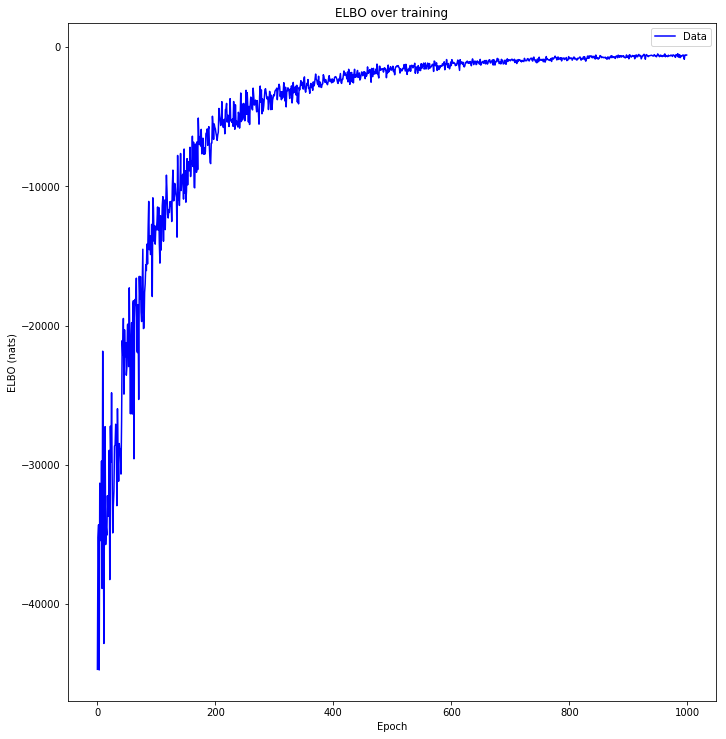

In [13]:
utils.plot_evidence_bounds(elbos.numpy())

In [14]:
ssm_smc = mcmc.step_resample_move_smc(ssm_training, moves=10)

In [15]:
_, inference, _ = ssm_smc(data=data)

In [16]:
for t in range(0, zs.shape[0]-1):
    key = generative.find(lambda k, v: str(t) in k and 'Deterministic' not in k)[0]
    z_t = 'Z_%d' % (t+1)
    accuracy = ((inference[key][z_t].value - utils.optional_to(generative[key][z_t], inference[key][z_t].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 0: 0.568461
SMC MSE at time 1: 0.244465
SMC MSE at time 2: 0.544479
SMC MSE at time 3: 2.254286
SMC MSE at time 4: 1.360744
SMC MSE at time 5: 1.978162
SMC MSE at time 6: 0.995055
SMC MSE at time 7: 3.137414
SMC MSE at time 8: 0.943967
SMC MSE at time 9: 1.034480
SMC MSE at time 10: 1.429404
SMC MSE at time 11: 0.879630
SMC MSE at time 12: 1.873753
SMC MSE at time 13: 1.495814
SMC MSE at time 14: 2.665206
SMC MSE at time 15: 0.986470
SMC MSE at time 16: 1.802212
SMC MSE at time 17: 0.983874
SMC MSE at time 18: 1.505938
SMC MSE at time 19: 0.793136
SMC MSE at time 20: 1.174396
SMC MSE at time 21: 1.270002
SMC MSE at time 22: 1.745043
SMC MSE at time 23: 1.365986
SMC MSE at time 24: 1.316054
SMC MSE at time 25: 5.340651
SMC MSE at time 26: 2.042710
SMC MSE at time 27: 1.916318
SMC MSE at time 28: 2.193391
SMC MSE at time 29: 1.352891
SMC MSE at time 30: 8.228937
SMC MSE at time 31: 1.210298
SMC MSE at time 32: 1.408103
SMC MSE at time 33: 0.922078
SMC MSE at time 34: 1.23

In [17]:
init_ssm_params

"{'delta__loc': 'tensor(1.0864, grad_fn=<CloneBackward>)', 'delta__scale': 'tensor(-1.8945, grad_fn=<CloneBackward>)', 'mu__loc': 'tensor(-0.4725, grad_fn=<CloneBackward>)', 'mu__scale': 'tensor(-1.0481, grad_fn=<CloneBackward>)', 'sigma__loc': 'tensor(-1.7774, grad_fn=<CloneBackward>)', 'sigma__scale': 'tensor(-0.8964, grad_fn=<CloneBackward>)'}"